In [2]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [11]:
fuzzers = ['zest', 'bedivfuzz', 'bedivfuzz-split']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
subjects = ['nashorn']
num_trials = 20
timeout = 180

results_base_dir = 'results/eval-bedivfuzz-split-nashorn-176307'

In [12]:
def trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    if fuzzer == 'bedivfuzz-split':
        zest_plot_data = pd.read_csv(
            os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'zest-results', 'plot_data'),
            skipinitialspace=True
        )

        df = pd.concat([zest_plot_data, df], ignore_index=True)

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject

    return df[['fuzzer', 'subject', 'trial', 'time', 'valid_inputs', 'invalid_inputs', 'unique_paths', 'b0', 'b1', 'b2']]

In [13]:
dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    dfs.append(trial_df(fuzzer=f, subject=s, trial=t))
trials = pd.concat(dfs)

In [14]:
trials.head()

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,unique_paths,b0,b1,b2
0,zest,nashorn,1,1,1,0,1,4803.0,4803.00,4803.00
19,zest,nashorn,1,2,2468,2109,1724,14484.0,7005.75,5749.17
39,zest,nashorn,1,3,6179,4690,4541,15034.0,7256.08,6014.87
59,zest,nashorn,1,4,11390,8297,8272,15432.0,7348.31,6122.43
79,zest,nashorn,1,5,15891,11436,12405,15583.0,7556.75,6310.35


In [15]:
trials['validity_rate'] = trials['valid_inputs'] / (trials['valid_inputs'] + trials['invalid_inputs'])

In [16]:
mean_trials = trials.groupby(['fuzzer', 'subject', 'time']).agg('mean')

In [17]:
mean_trials

trial  valid_inputs  invalid_inputs  unique_paths  \
fuzzer    subject time                                                      
bedivfuzz nashorn 1      10.5          0.55            0.45          1.00   
                  2      10.5       3476.80         1951.85       1823.60   
                  3      10.5      10022.70         4217.75       5213.05   
                  4      10.5      18489.90         6137.65       9575.60   
                  5      10.5      27534.85         7750.15      14620.45   
...                       ...           ...             ...           ...   
zest      nashorn 176    10.5     239850.70       210097.40     322072.15   
                  177    10.5     240299.20       210535.45     322765.65   
                  178    10.5     240730.90       210982.40     323456.85   
                  179    10.5     241178.60       211435.75     324163.80   
                  180    10.5     241624.25       211882.30     324856.00   

                               b0         b1         b2  validity_rate  
fuzzer    subject time                                                  
bedivfuzz nashorn 1       3574.25  3574.2500  3574.2500       0.550000  
                  2      13803.10  6878.4505  5712.8015       0.640529  
                  3      14578.10  7556.1040  6407.9630       0.703811  
                  4      14930.85  7772.2255  6698.5965       0.750499  
                  5      15188.05  7936.2890  6902.1945       0.780477  
...                           ...        ...        ...            ...  
zest      nashorn 176   194490.70  8724.1845  7675.9185       0.539552  
                  177   194932.95  8724.2600  7676.0400       0.539507  
                  178   195371.25  8724.3855  7676.1130       0.539435  
                  179   195822.90  8724.5955  7676.2870       0.539371  
                  180   196270.70  8724.8375  7676.4245       0.539314  

[540 rows x 8 columns]

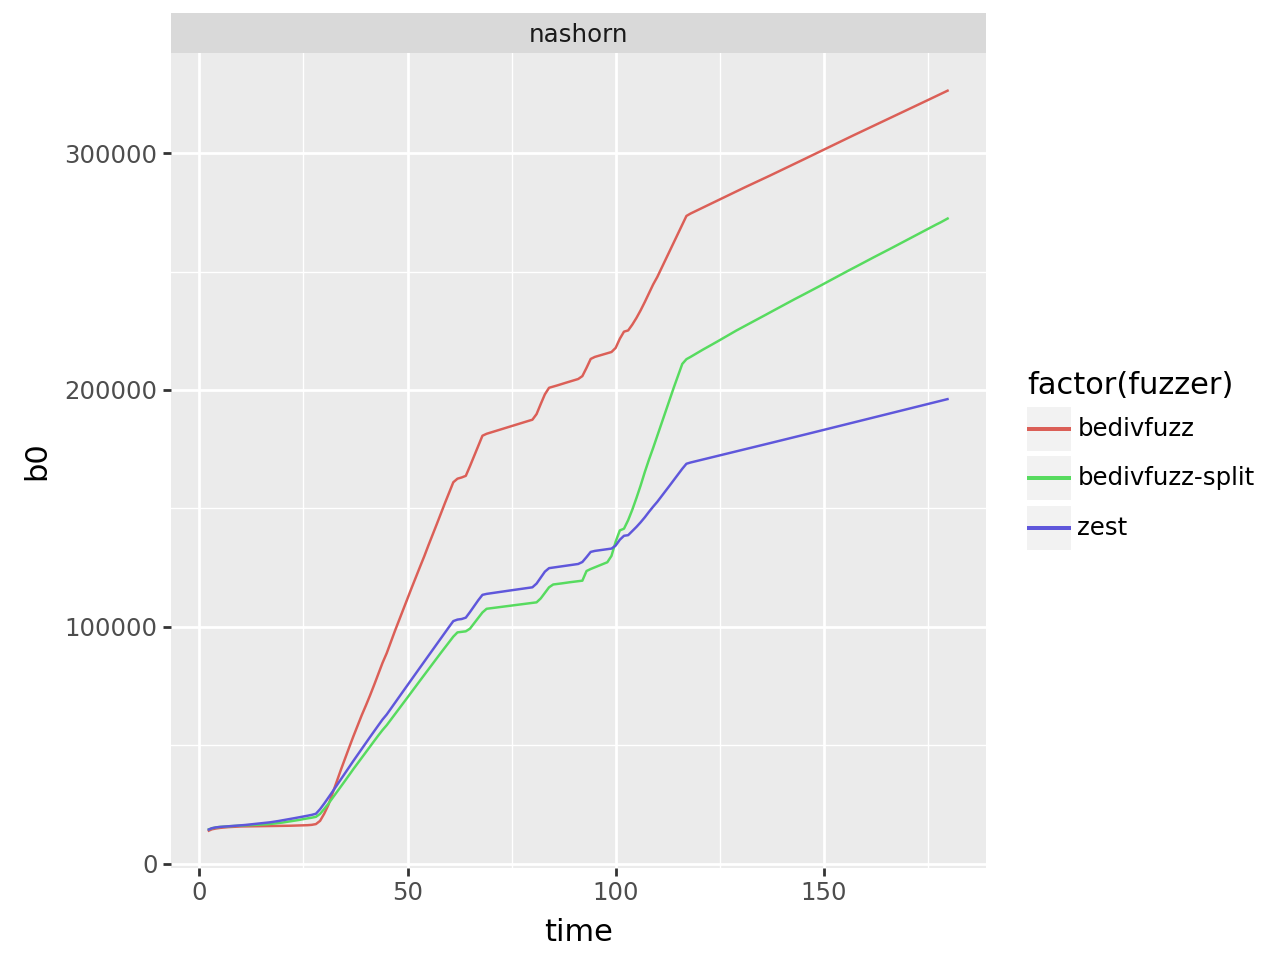

In [19]:
(ggplot(mean_trials.reset_index().query("time > 1"), aes("time", "b0", color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
)

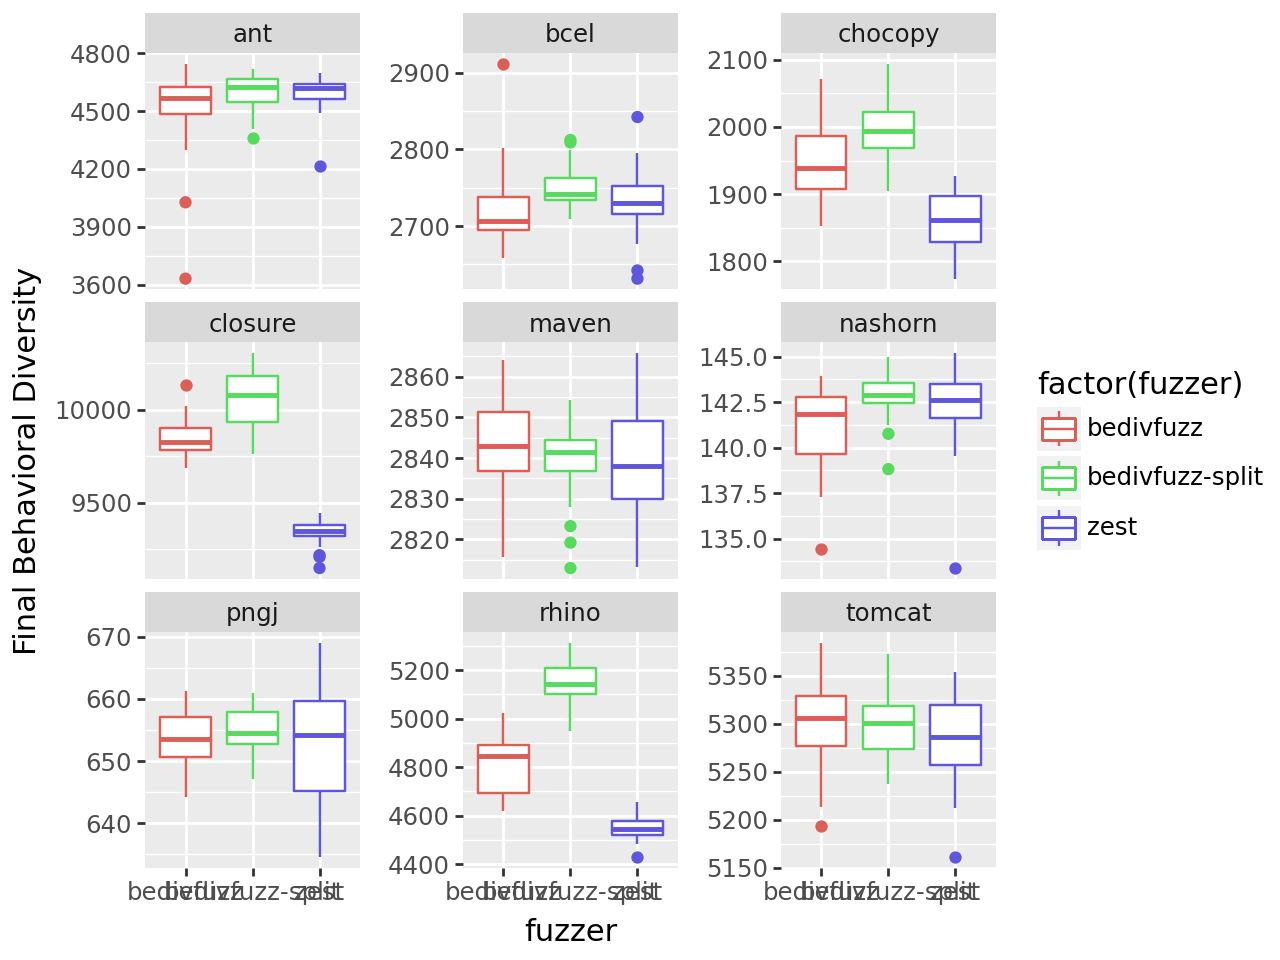

In [22]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b1", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [61]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,unique_paths,b0,b1,b2,validity_rate
3557,zest,ant,1,180,110363,273200,163383,6825.0,4676.33,4535.14,0.287731
3558,zest,ant,2,180,126456,265216,176134,6870.0,4665.15,4512.57,0.322862
3557,zest,ant,3,180,121684,250565,152393,6251.0,4668.65,4528.21,0.326889
3557,zest,ant,4,180,126351,254341,163233,6288.0,4674.42,4525.35,0.331898
3556,zest,ant,5,180,110876,253944,158623,6821.0,4674.28,4533.59,0.303920
...,...,...,...,...,...,...,...,...,...,...,...
3565,bedivfuzz-split,tomcat,16,180,232657,45146,230395,8322.0,5357.89,5154.30,0.837489
3562,bedivfuzz-split,tomcat,17,180,223014,30465,211875,8383.0,5280.32,5087.39,0.879813
3565,bedivfuzz-split,tomcat,18,180,229498,44821,223086,8373.0,5336.39,5130.83,0.836610
3565,bedivfuzz-split,tomcat,19,180,233119,26471,217277,8319.0,5251.71,5064.66,0.898028


In [24]:
import scipy.stats as stats

In [28]:
metric = 'b1'
alpha = 0.01
time = 180
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz-split' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : bedivfuzz
closure   : bedivfuzz
maven     : not significant
nashorn   : not significant
pngj      : not significant
rhino     : bedivfuzz
tomcat    : not significant


In [29]:
import math

crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    if str(exception_class) == 'nan' or "OutOfMemoryError" in str(exception_class):
        return -1
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [30]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [31]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [32]:
crash_trials = crash_trials.loc[crash_trials['crash_id'] != -1]

In [33]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer         
bcel     bedivfuzz          2766590
         bedivfuzz-split    2717301
         zest               4362516
closure  bedivfuzz          6891526
         bedivfuzz-split    3325718
         zest               3825946
nashorn  bedivfuzz-split    4079040
rhino    bedivfuzz          5946736
         bedivfuzz-split    1030996
         zest               5662388
Name: # ttd, dtype: int64

In [35]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer   
bcel     zest         2
closure  bedivfuzz    2
         zest         5
rhino    bedivfuzz    3
         zest         2
Name: crash_id, dtype: int64

In [36]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer', 'crash_id']).agg('mean').round(0).astype(int)

subject  fuzzer     crash_id
bcel     zest       0.0         1820713
                    1.0         2865616
closure  bedivfuzz  2.0         1610896
                    5.0         1449209
         zest       2.0         1029212
                    3.0         2743993
                    4.0         3285143
                    5.0         5459950
                    6.0         8506055
rhino    bedivfuzz  7.0          585640
                    8.0          299418
                    9.0          267042
         zest       7.0          129849
                    8.0          163704
Name: # ttd, dtype: int64

In [37]:
crash_to_id

{('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'org.apache.bcel.util.ClassPath.getClassFile(ClassPath.java:656)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:705)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:679)'): 0,
 ('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'java.base/jdk.internal.util.Preconditions.outOfBounds(Preconditions.java:64)-java.base/jdk.internal.util.Preconditions.outOfBoundsCheckIndex(Preconditions.java:70)-java.base/jdk.internal.util.Preconditions.checkIndex(Preconditions.java:248)'): 1,
 ('class java.lang.IllegalStateException',
  'com.google.javascript.jscomp.jarjar.com.google.common.base.Preconditions.checkState(Preconditions.java:590)-com.google.javascript.jscomp.LightweightMessageFormatter.padMultipleLines(LightweightMessageFormatter.java:237)-com.google.javascript.jscomp.LightweightMessageFormatter.getExcerptWithPosition(LightweightMessageFormatter.java:169)'): 2,
 ('class java.lang.Nu

In [38]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].unique()

subject  fuzzer   
bcel     zest                        [0.0, 1.0]
closure  bedivfuzz                   [5.0, 2.0]
         zest         [2.0, 3.0, 4.0, 5.0, 6.0]
rhino    bedivfuzz              [9.0, 8.0, 7.0]
         zest                        [7.0, 8.0]
Name: crash_id, dtype: object

In [39]:
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
   .groupby(['subject', 'fuzzer', 'crash_id']).agg('count')

subject  fuzzer     crash_id
bcel     zest       0.0         10
                    1.0         10
closure  bedivfuzz  2.0         10
                    5.0         10
         zest       2.0         10
                    3.0         10
                    4.0         10
                    5.0         10
                    6.0         10
rhino    bedivfuzz  7.0         10
                    8.0         10
                    9.0         10
         zest       7.0         10
                    8.0         10
Name: # ttd, dtype: int64